In [1]:
%load_ext autoreload
%autoreload 2
from system.bio_model.cognitive_map import LifelongCognitiveMap
import system.plotting.plotResults as plot
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
!ls ../system/bio_model/data/cognitive_map/*.gpickle

../system/bio_model/data/cognitive_map/after_exploration.gpickle
../system/bio_model/data/cognitive_map/after_lifelong_learning.gpickle
../system/bio_model/data/cognitive_map/cognitive_map_full.gpickle
../system/bio_model/data/cognitive_map/cognitive_map_partial_2.gpickle
../system/bio_model/data/cognitive_map/cognitive_map_partial_3.gpickle
../system/bio_model/data/cognitive_map/cognitive_map_partial.gpickle
../system/bio_model/data/cognitive_map/directional.gpickle
../system/bio_model/data/cognitive_map/disjoint.gpickle
../system/bio_model/data/cognitive_map/handcrafted.gpickle
../system/bio_model/data/cognitive_map/linear_sunburst.after_exploration.gpickle
../system/bio_model/data/cognitive_map/linear_sunburst.after_exploration+re--network.gpickle
../system/bio_model/data/cognitive_map/linear_sunburst.after_lifelong_learning.gpickle
../system/bio_model/data/cognitive_map/linear_sunburst.handcrafted.gpickle
../system/bio_model/data/cognitive_map/net-re_mse_weights+spikings+conv.50.gp

## Computing grid cell drift

In [6]:
from system.controller.simulation.pybullet_environment import PybulletEnvironment
from system.controller.local_controller.local_navigation import setup_gc_network

map_file = 'after_exploration.gpickle'
cognitive_map = LifelongCognitiveMap(reachability_estimator=None, load_data_from=map_file)
with PybulletEnvironment(env_model="linear_sunburst") as env:
    gc_network = setup_gc_network(env.dt)
    cognitive_map.test_place_cell_network(env, gc_network)

Decoding goal vector to place Cell 0 out of 77


KeyboardInterrupt: 

## Getting reachability from map nodes

In [2]:
map_file = "linear_sunburst.after_lifelong_learning.gpickle"
cognitive_map = LifelongCognitiveMap(reachability_estimator=None, load_data_from=map_file, debug=False)

In [8]:
import networkx as nx

node_network = cognitive_map.node_network
positions = { node: nodeval['pos'] for node, nodeval in node_network.nodes.items() }

def draw_network_with_re(re):
    fig, axes = plt.subplots(1, 2)
    reachabilities = []
    for start, end in node_network.edges:
        reachabilities.append(re.reachability_factor(start, end))
    reachabilities_binary = [ (0, 0.5, 0) if edge > re.threshold_reachable else (1, 0.5, 0.5) for edge in reachabilities ]
    nx.draw_networkx(node_network, node_size=120, with_labels=False, pos=positions, edge_color=reachabilities, ax=axes[0])
    nx.draw_networkx(node_network, node_size=120, with_labels=False, pos=positions, edge_color=reachabilities_binary, ax=axes[1])
    plt.show()

from system.controller.reachability_estimator.reachability_estimation import reachability_estimator_factory

##### Spikings

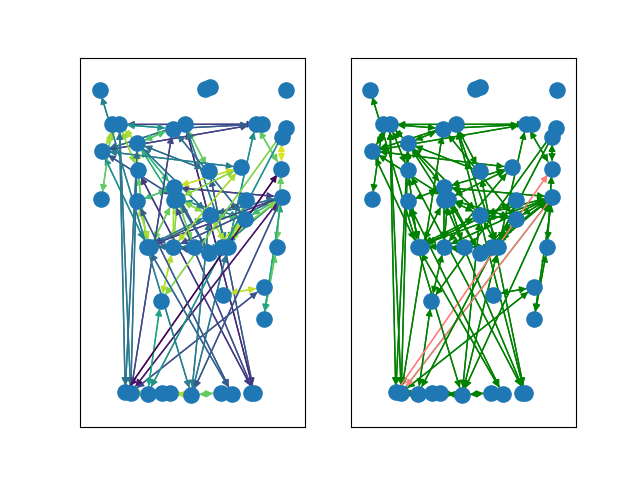

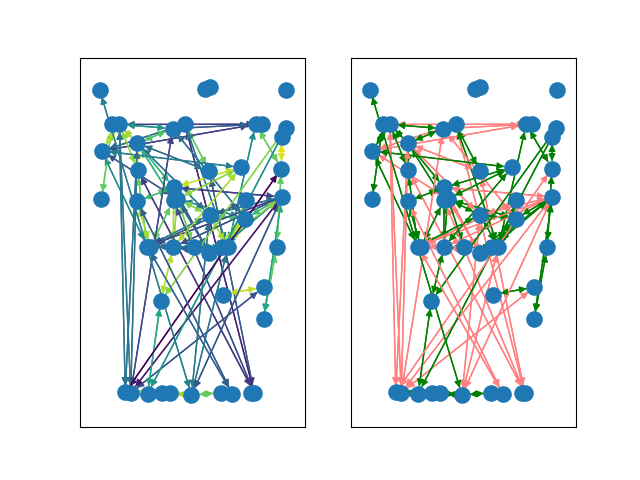

In [9]:
re = reachability_estimator_factory('spikings')
draw_network_with_re(re)
re.threshold_reachable = 0.6
draw_network_with_re(re)

##### View_overlap

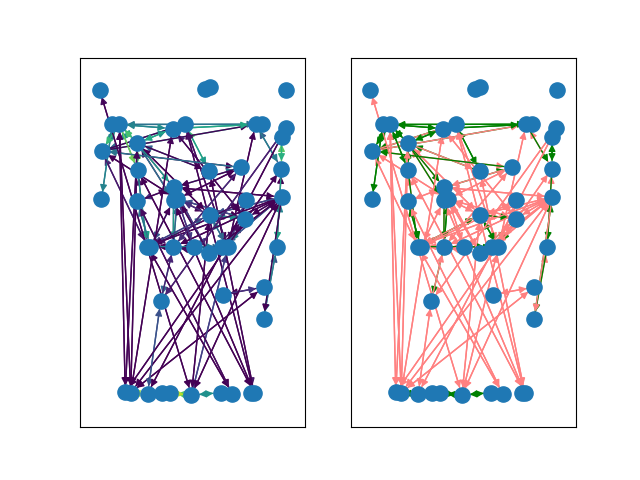

In [10]:
draw_network_with_re(reachability_estimator_factory('view_overlap', env_model='linear_sunburst'))

###### Checking why the ViewOverlap controller doesn't work

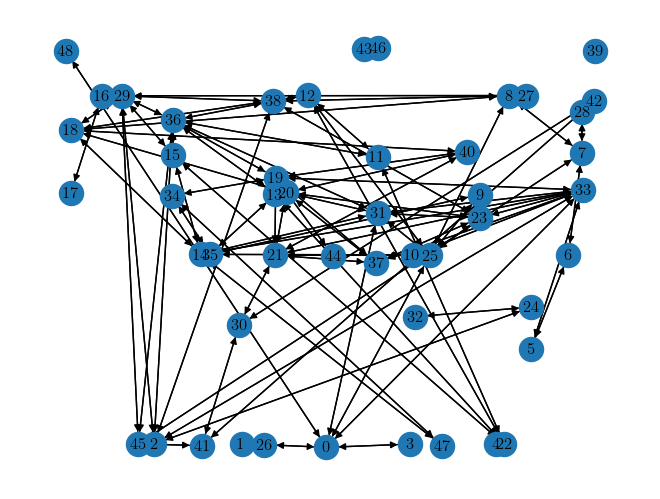

    def reachability_factor(self, start: PlaceInfo, goal: PlaceInfo) -> float:
        """ Reachability Score based on the view overlap of start and goal in the environment """
        # untested and unfinished
        start_pos = start.pos
        goal_pos = goal.pos

        heading1 = np.degrees(np.arctan2(goal_pos[0] - start_pos[0], goal_pos[1] - start_pos[1]))

        overlap_ratios = self.map_layout.view_overlap(start_pos, heading1, goal_pos, heading1, self.fov, mode='plane')

        return (overlap_ratios[0] + overlap_ratios[1]) / 2


In [8]:
re = reachability_estimator_factory('view_overlap', env_model='linear_sunburst')
%psource re.reachability_factor
nodes = list(node_network.nodes)
cognitive_map.draw()

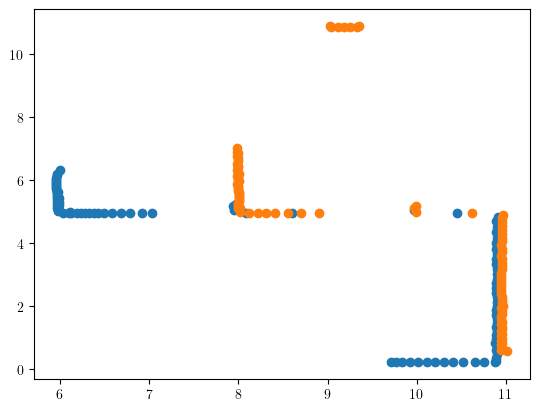

88.21659538329148 (0.36, 0.67)


In [9]:
import numpy as np
start, goal = nodes[0], nodes[3]
start_pos = start.pos
goal_pos = goal.pos

heading1 = np.degrees(np.arctan2(goal_pos[0] - start_pos[0], goal_pos[1] - start_pos[1]))
overlap_ratios = re.map_layout.view_overlap(start_pos, heading1, goal_pos, heading1, re.fov, mode='plane', vis=True)
print(heading1, overlap_ratios)

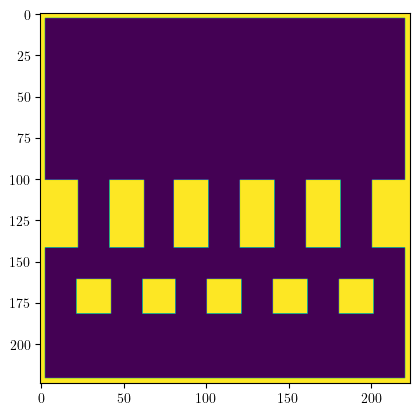

In [10]:
import matplotlib.pyplot as plt
plt.imshow(re.map_layout.binary_occupancy)

##### Network

In [26]:
!ls ../system/controller/reachability_estimator/data/models/

autoencoder0.25
autoencoder100.25
autoencoder1.25
autoencoder16.25
autoencoder20.25
autoencoder4.25
autoencoder50.10
autoencoder50.15
autoencoder50.20
autoencoder50.25
autoencoder50.5
autoencoder80.10
autoencoder80.15
autoencoder80.20
autoencoder80.25
autoencoder80.5
no_siamese_mse_updated.10
no_siamese_mse_updated.15
no_siamese_mse_updated.5
reachability_network-260624-3colors+lidar--ego_bc.25
reachability_network-260624-3colors+spikings+lidar--raw_lidar+conv.25
reachability_network-260624-boolor+spikings+lidar--raw_lidar+conv.25
reachability_network-260624+dist.25
reachability_network-260624+lidar--raw_lidar+conv.25
reachability_network-260624+spikings+conv.25
reachability_network-260624+spikings+lidar--allo_bc+conv.25
reachability_network-260624+spikings+lidar--ego_bc+conv.25
reachability_network-260624+spikings+lidar--raw_lidar.25
reachability_network-260624+spikings+lidar--raw_lidar+conv.25
reachability_network-260624+spikings+lidar--raw_lidar+dist+conv.25
reachability_network-260

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


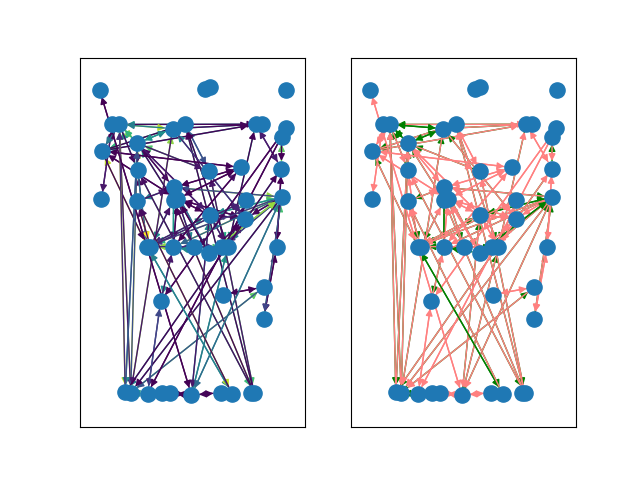

In [11]:
from system.controller.reachability_estimator.ReachabilityDataset import SampleConfig

draw_network_with_re(reachability_estimator_factory(
    'neural_network',
    weights_file='re_mse_weights.50',
    config=SampleConfig(grid_cell_spikings=True)
))

2024-07-26 19:02:13.851319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


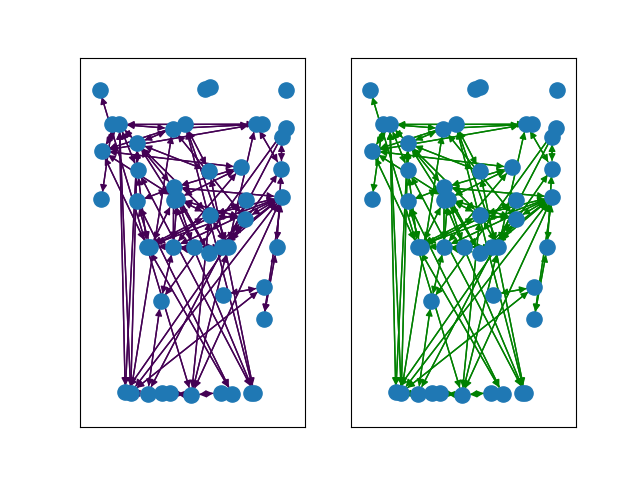

In [13]:
from system.controller.reachability_estimator.training.train_multiframe_dst import Hyperparameters

draw_network_with_re(reachability_estimator_factory(
    'neural_network',
    weights_file='reachability_network-260624+spikings+conv.25',
    config=SampleConfig(grid_cell_spikings=True),
    backbone_classname='convolutional',
))

### Checking where that reachability comes from

In [3]:
re.threshold_reachable

0.3

In [4]:
nodes = list(cognitive_map.node_network.nodes)
def get_factor(i, j):
    (node_i, node_j) = (nodes[x] for x in (i, j))
    re_factor = re.reachability_factor(node_i, node_j)
    try:
        saved_factor = cognitive_map.node_network.edges[node_i, node_j]['connectivity_probability']
    except KeyError:
        saved_factor = None
    return re_factor, saved_factor
get_factor(0, 1)

(0.7150000000000001, 0.7150000000000001)

In [6]:
from itertools import pairwise
for i, j in pairwise(range(len(nodes))):
    print(f'[{i}] -> [{j}]:', get_factor(i, j), get_factor(j, i))

[0] -> [1]: (0.7150000000000001, 0.7150000000000001) (0.7849999999999999, 0.7150000000000001)
[1] -> [2]: (0.75, 0.75) (0.75, 0.75)
[2] -> [3]: (0.745, 0.745) (0.775, 0.745)
[3] -> [4]: (0.635, 0.635) (0.815, 0.635)
[4] -> [5]: (0.7050000000000001, 0.7050000000000001) (0.69, 0.7050000000000001)
[5] -> [6]: (0.7849999999999999, 0.7849999999999999) (0.76, 0.7849999999999999)
[6] -> [7]: (0.77, 0.77) (0.71, 0.77)
[7] -> [8]: (0.36, 0.36) (0.66, 0.36)
[8] -> [9]: (0.59, 0.59) (0.515, 0.59)
[9] -> [10]: (0.36, 0.36) (0.435, 0.36)
[10] -> [11]: (0.305, 0.305) (0.27, 0.305)
[11] -> [12]: (0.0, None) (0.025, None)
[12] -> [13]: (0.62, 0.62) (0.445, 0.62)
[13] -> [14]: (0.505, 0.505) (0.22, 0.505)
[14] -> [15]: (0.66, 0.66) (0.195, 0.66)
[15] -> [16]: (0.42, 0.42) (0.43500000000000005, 0.42)
[16] -> [17]: (0.6950000000000001, 0.6950000000000001) (0.3, 0.6950000000000001)
[17] -> [18]: (0.32, 0.32) (0.505, 0.32)
[18] -> [19]: (0.61, 0.61) (0.56, 0.61)
[19] -> [20]: (0.47, 0.47) (0.61, 0.47)
[20]

#### Some more stats
to debug if the reachability does not make sense

In [17]:
import numpy as np
from system.controller.reachability_estimator.types import PlaceInfo
for i, j in pairwise(range(18)):
    node_i, node_j = nodes[i], nodes[j]
    middle = (node_i.pos + node_j.pos) / 2
    node_ij = PlaceInfo(pos=middle, angle=0, lidar=None, img=None, spikings=None)
    print(f'[{i}] -({re.reachability_factor(node_i, node_ij)})> [{i}.5] -({re.reachability_factor(node_ij, node_j)})> [{j}]')

[0] -(-0.8302635584928693)> [0.5] -(-0.8302635584928697)> [1]
[1] -(-0.8568140175843595)> [1.5] -(-0.8568140175843598)> [2]
[2] -(-2.501533277732558)> [2.5] -(-2.501533277732558)> [3]
[3] -(-0.8467862963514505)> [3.5] -(-0.8467862963514505)> [4]
[4] -(-0.827746202734712)> [4.5] -(-0.827746202734712)> [5]
[5] -(-0.8223541891237505)> [5.5] -(-0.8223541891237497)> [6]
[6] -(-0.8186241225164983)> [6.5] -(-0.8186241225164983)> [7]
[7] -(-0.8473762745932515)> [7.5] -(-0.8473762745932509)> [8]
[8] -(-0.829908450745501)> [8.5] -(-0.8299084507455005)> [9]
[9] -(-0.8125709565277949)> [9.5] -(-0.8125709565277955)> [10]
[10] -(-0.8464369468644735)> [10.5] -(-0.8464369468644719)> [11]
[11] -(-0.8358955536418636)> [11.5] -(-0.835895553641863)> [12]
[12] -(-0.8446180989758892)> [12.5] -(-0.8446180989758892)> [13]
[13] -(-0.8711103234405992)> [13.5] -(-0.8711103234405992)> [14]
[14] -(-0.8279291257838153)> [14.5] -(-0.8279291257838153)> [15]
[15] -(-0.8419868739424984)> [15.5] -(-0.8419868739424973)> 

# Merging maps

In [2]:
map_files = "cognitive_map_partial", "cognitive_map_partial_3"
map_files = [ file + ".gpickle" for file in map_files ]
maps = [ LifelongCognitiveMap(reachability_estimator=None, load_data_from=map_file, debug=False) for map_file in map_files ]

In [3]:
for i, map in enumerate(maps):
    print("Edge for map", i)
    edge = next(iter(map.node_network.edges))
    print(map.node_network.edges[edge])

Edge for map 0
{'weight': 0.0574221613648944, 'connectivity_probability': 0.95, 'mu': 0.05960367940133437, 'sigma': 0.005669467095138408}
Edge for map 1
{'weight': 0.1723835877321686, 'connectivity_probability': 0.9377825618945104, 'mu': 0.16670678766968194, 'sigma': 0.008660254037844387, 'length': 107}


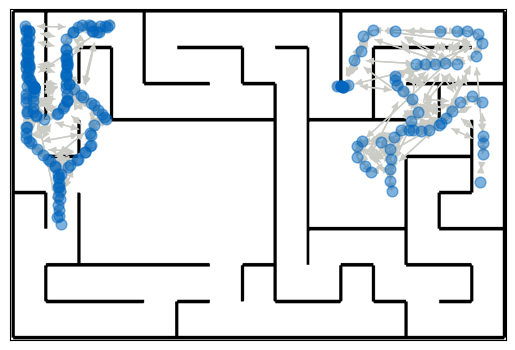

In [10]:
import networkx
new_map = LifelongCognitiveMap(reachability_estimator=None, debug=False)
new_graph = new_map.node_network
for map in maps:
    for node in map.node_network:
        new_graph.add_node(node, pos=node.pos)
    new_graph.add_edges_from(((*edge_start_and_end, edge) for (edge_start_and_end, edge) in map.node_network.edges.items()))
plot.plotTrajectoryInEnvironment(env_model="Savinov_val3", cognitive_map=new_map, trajectory=False)

In [12]:
new_map.save("disjoint.gpickle")

# Add connections to an existing map

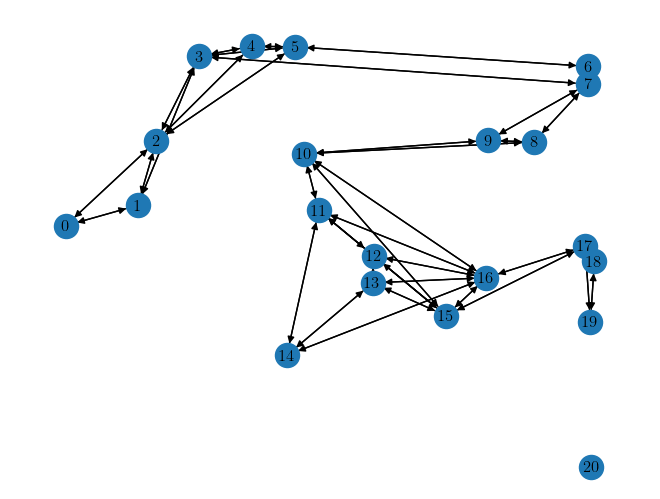

In [7]:
cognitive_map = LifelongCognitiveMap(reachability_estimator=None, load_data_from='artifacts/vo_0.5.gpickle')
env_model = 'Savinov_val3'
node_network = cognitive_map.node_network
cognitive_map.draw()

In [13]:
from system.controller.reachability_estimator.reachability_estimation import reachability_estimator_factory
from system.bio_model.cognitive_map import sample_normal

def add_connections_to_map(cognitive_map, re, add=True, remove=False):
    node_network = cognitive_map.node_network

    for i, ni in enumerate(node_network.nodes):
        for j, nj in enumerate(node_network.nodes):
            if i != j:
                reachable, factor = re.get_reachability(ni, nj)
                if reachable and add and (nj not in node_network[ni] or 'connectivity_probability' not in node_network.edges[nj, ni]):
                    cognitive_map.add_bidirectional_edge_to_map(
                        ni, nj,
                        w=sample_normal(1-factor, cognitive_map.sigma),
                        connectivity_probability=re.get_connectivity_probability(factor),
                        mu=1-factor,
                        sigma=cognitive_map.sigma,
                    )
                if not reachable and remove and (nj in node_network[ni]):
                    cognitive_map.remove_bidirectional_edge(ni, nj)

0.3
Adding bidirectional edge: p=6, q=4, weight=0.5252146171674488
Adding bidirectional edge: p=8, q=6, weight=0.5363946929808738
Adding bidirectional edge: p=9, q=6, weight=0.5367495575616635
Adding bidirectional edge: p=14, q=12, weight=0.6308203764761106
Adding bidirectional edge: p=15, q=14, weight=0.5251133115822362
Adding bidirectional edge: p=18, q=16, weight=0.6189022725116694
Adding bidirectional edge: p=20, q=17, weight=0.639981365888039
Adding bidirectional edge: p=20, q=18, weight=0.48967615517211216
Adding bidirectional edge: p=20, q=19, weight=0.5287963388783807


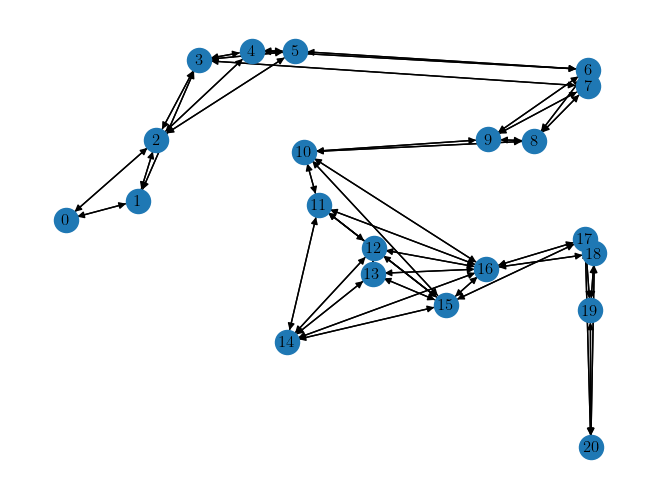

In [8]:
re = reachability_estimator_factory('view_overlap', env_model=env_model)
print(re.threshold_reachable)

add_connections_to_map(cognitive_map, re)

cognitive_map.draw()

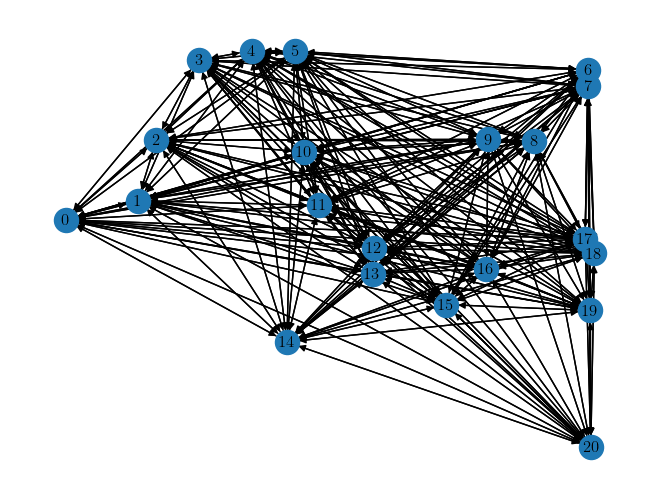

deleting edge [0-3]: conn 0.0
deleting edge [0-5]: conn 0.0
deleting edge [0-6]: conn 0.0
deleting edge [0-7]: conn 0.0
deleting edge [0-8]: conn 0.0
deleting edge [0-9]: conn 0.0
deleting edge [0-10]: conn 0.0
deleting edge [0-11]: conn 0.0
deleting edge [0-12]: conn 0.0
deleting edge [0-13]: conn 0.0
deleting edge [0-14]: conn 0.0
deleting edge [0-15]: conn 0.0
deleting edge [0-16]: conn 0.0
deleting edge [0-17]: conn 0.0
deleting edge [0-18]: conn 0.0
deleting edge [0-19]: conn 0.0
deleting edge [0-20]: conn 0.0
deleting edge [1-5]: conn 0.0
deleting edge [1-6]: conn 0.0
deleting edge [1-7]: conn 0.0
deleting edge [1-8]: conn 0.0
deleting edge [1-9]: conn 0.0
deleting edge [1-10]: conn 0.0
deleting edge [1-11]: conn 0.0
deleting edge [1-12]: conn 0.0
deleting edge [1-13]: conn 0.0
deleting edge [1-14]: conn 0.0
deleting edge [1-15]: conn 0.0
deleting edge [1-16]: conn 0.0
deleting edge [1-17]: conn 0.0
deleting edge [1-18]: conn 0.0
deleting edge [1-19]: conn 0.0
deleting edge [1-20

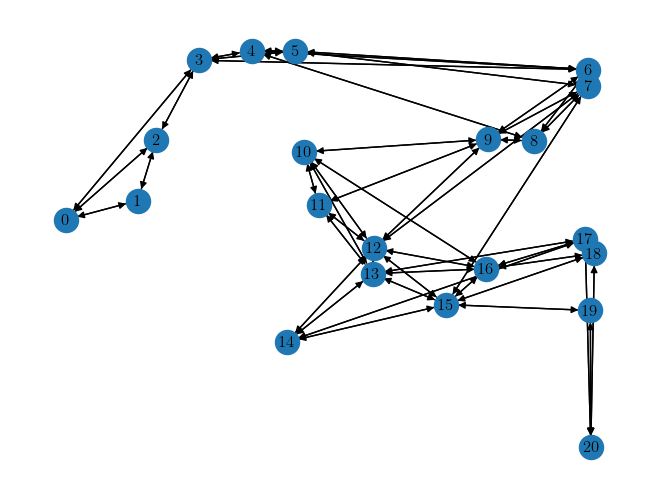

deleting edge [0-3]: conn 0.24
Adding bidirectional edge: p=1, q=3, weight=0.6017523420454631
Adding bidirectional edge: p=2, q=4, weight=0.49613026896222356
Adding bidirectional edge: p=2, q=5, weight=0.5907154317205894
Adding bidirectional edge: p=3, q=0, weight=0.7572118688379244
deleting edge [3-1]: conn 0.4
deleting edge [3-6]: conn 0.225
Adding bidirectional edge: p=3, q=7, weight=0.6533255232072162
deleting edge [4-2]: conn 0.54
deleting edge [4-8]: conn 0.14
deleting edge [5-2]: conn 0.42
deleting edge [5-7]: conn 0.27
Adding bidirectional edge: p=6, q=3, weight=0.7695582078968648
deleting edge [6-8]: conn 0.485
deleting edge [6-9]: conn 0.48
deleting edge [7-3]: conn 0.325
Adding bidirectional edge: p=7, q=5, weight=0.7567486819278365
Adding bidirectional edge: p=7, q=10, weight=0.7638467268005238
deleting edge [7-12]: conn 0.235
deleting edge [7-15]: conn 0.16499999999999998
Adding bidirectional edge: p=8, q=6, weight=0.5136136857008111
Adding bidirectional edge: p=8, q=10, w

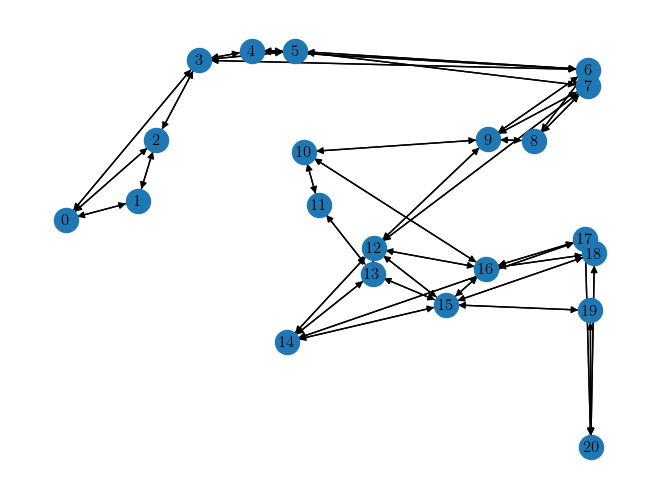

deleting edge [0-3]: conn 0.24
Adding bidirectional edge: p=1, q=3, weight=0.5916280839894609
deleting edge [2-0]: conn 0.44
Adding bidirectional edge: p=2, q=4, weight=0.44187136455010523
Adding bidirectional edge: p=2, q=5, weight=0.5798438799604138
deleting edge [3-1]: conn 0.4
deleting edge [3-6]: conn 0.225
Adding bidirectional edge: p=3, q=7, weight=0.7169708381924595
deleting edge [4-2]: conn 0.54
deleting edge [4-6]: conn 0.465
deleting edge [5-2]: conn 0.42
deleting edge [5-7]: conn 0.27
Adding bidirectional edge: p=6, q=4, weight=0.5224046251125791
deleting edge [6-8]: conn 0.485
deleting edge [6-9]: conn 0.48
deleting edge [7-3]: conn 0.325
deleting edge [7-12]: conn 0.235
Adding bidirectional edge: p=8, q=6, weight=0.5180245330794385
Adding bidirectional edge: p=8, q=10, weight=0.4628777443230555
Adding bidirectional edge: p=9, q=6, weight=0.5121835615057551
deleting edge [9-12]: conn 0.28500000000000003
deleting edge [10-8]: conn 0.545
Adding bidirectional edge: p=10, q=15

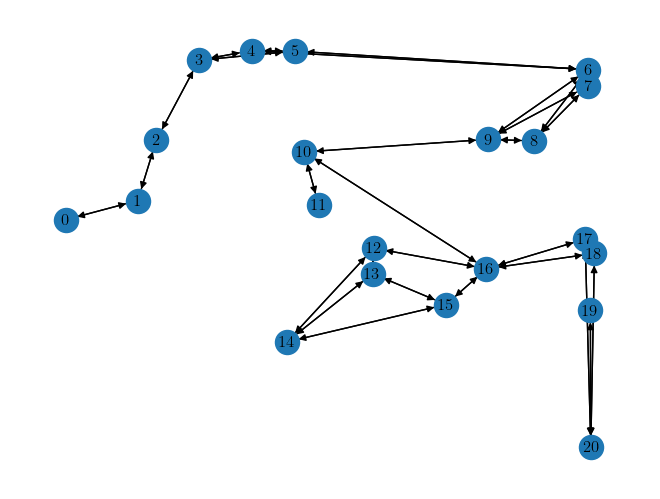

Adding bidirectional edge: p=0, q=2, weight=0.5347576610397858
Adding bidirectional edge: p=1, q=3, weight=0.5912875463954929
deleting edge [2-0]: conn 0.44
deleting edge [2-1]: conn 0.48
Adding bidirectional edge: p=2, q=4, weight=0.4563507173877154
Adding bidirectional edge: p=2, q=5, weight=0.5914964442200904
deleting edge [3-1]: conn 0.4
deleting edge [4-2]: conn 0.54
deleting edge [4-6]: conn 0.465
deleting edge [5-2]: conn 0.42
deleting edge [5-3]: conn 0.635
deleting edge [5-6]: conn 0.325
Adding bidirectional edge: p=6, q=4, weight=0.5273578452580066
Adding bidirectional edge: p=6, q=5, weight=0.579303401317652
deleting edge [6-8]: conn 0.485
deleting edge [6-9]: conn 0.48
Adding bidirectional edge: p=8, q=6, weight=0.5154042737941765
Adding bidirectional edge: p=8, q=10, weight=0.46329632863280573
Adding bidirectional edge: p=9, q=6, weight=0.49984458217257005
deleting edge [9-8]: conn 0.665
deleting edge [10-8]: conn 0.545
deleting edge [10-9]: conn 0.58
Adding bidirectional 

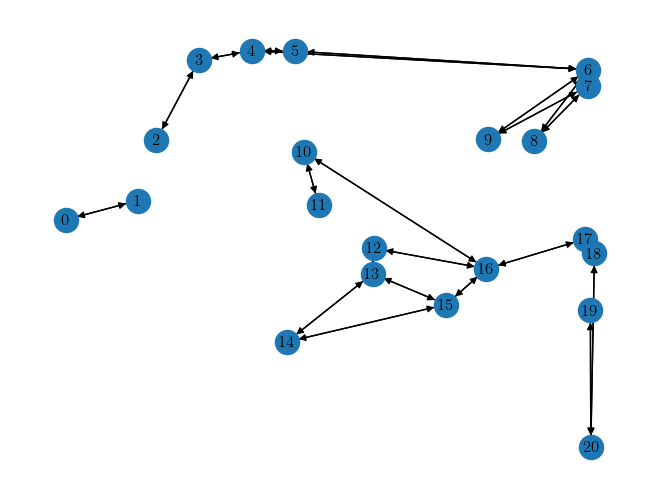

deleting edge [1-0]: conn 0.72
Adding bidirectional edge: p=2, q=4, weight=0.45932735346926257
deleting edge [3-2]: conn 0.595
Adding bidirectional edge: p=3, q=5, weight=0.34702229286826014
deleting edge [4-2]: conn 0.54
deleting edge [4-3]: conn 0.73
deleting edge [4-6]: conn 0.465
deleting edge [5-3]: conn 0.635
deleting edge [5-4]: conn 0.6599999999999999
deleting edge [5-6]: conn 0.425
deleting edge [6-8]: conn 0.485
deleting edge [6-9]: conn 0.48
deleting edge [7-6]: conn 0.5900000000000001
deleting edge [8-7]: conn 0.685
Adding bidirectional edge: p=8, q=9, weight=0.3172173206197605
Adding bidirectional edge: p=8, q=10, weight=0.45738736212685627
deleting edge [9-7]: conn 0.585
deleting edge [9-8]: conn 0.665
Adding bidirectional edge: p=9, q=10, weight=0.4143647582151653
deleting edge [10-8]: conn 0.545
deleting edge [10-9]: conn 0.58
deleting edge [10-16]: conn 0.47
deleting edge [11-10]: conn 0.725
Adding bidirectional edge: p=11, q=12, weight=0.42539822472595246
deleting edg

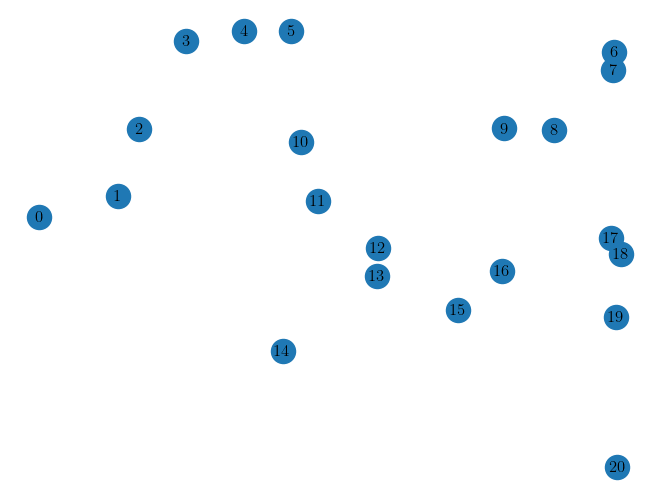

Adding bidirectional edge: p=0, q=1, weight=0.27897655093642404
deleting edge [1-0]: conn 0.72
Adding bidirectional edge: p=3, q=4, weight=0.2721320480627596
Adding bidirectional edge: p=3, q=5, weight=0.3776513872227992
deleting edge [4-3]: conn 0.73
Adding bidirectional edge: p=4, q=5, weight=0.3408184734522753
deleting edge [5-3]: conn 0.635
deleting edge [5-4]: conn 0.6599999999999999
Adding bidirectional edge: p=7, q=8, weight=0.300103864616247
deleting edge [8-7]: conn 0.685
Adding bidirectional edge: p=8, q=9, weight=0.32699371109598896
deleting edge [9-8]: conn 0.665
Adding bidirectional edge: p=10, q=11, weight=0.2572100622943028
deleting edge [11-10]: conn 0.725
Adding bidirectional edge: p=12, q=13, weight=0.3649649146642938
deleting edge [13-12]: conn 0.62
Adding bidirectional edge: p=13, q=14, weight=0.3637329078045829
Adding bidirectional edge: p=13, q=16, weight=0.264864406550361
deleting edge [14-13]: conn 0.66
Adding bidirectional edge: p=15, q=16, weight=0.23973109914

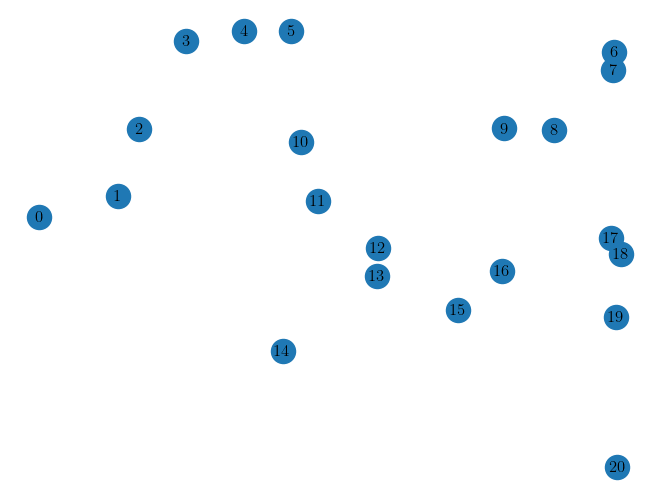

Adding bidirectional edge: p=0, q=1, weight=0.3111051670823305
deleting edge [1-0]: conn 0.72
Adding bidirectional edge: p=3, q=4, weight=0.2825814886222595
deleting edge [4-3]: conn 0.73
Adding bidirectional edge: p=10, q=11, weight=0.27207571189343693
deleting edge [11-10]: conn 0.725
Adding bidirectional edge: p=13, q=16, weight=0.28375033872792627
Adding bidirectional edge: p=15, q=16, weight=0.24302714496420127
deleting edge [16-13]: conn 0.72
deleting edge [16-15]: conn 0.76
Adding bidirectional edge: p=17, q=18, weight=0.127381664406458
Adding bidirectional edge: p=17, q=19, weight=0.2307172299340952
deleting edge [18-17]: conn 0.88
Adding bidirectional edge: p=18, q=19, weight=0.23457182665871676
deleting edge [19-17]: conn 0.755
deleting edge [19-18]: conn 0.765


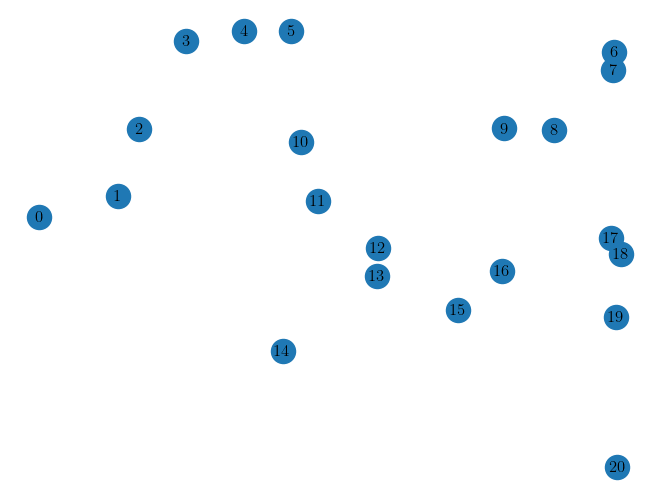

Adding bidirectional edge: p=17, q=18, weight=0.11711241566844133
deleting edge [18-17]: conn 0.88


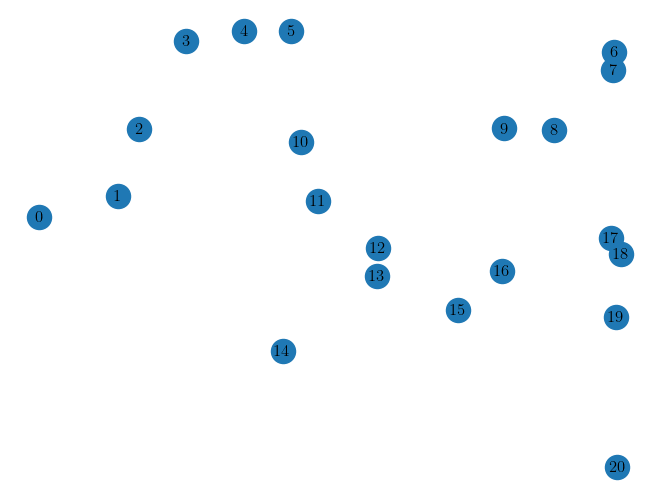

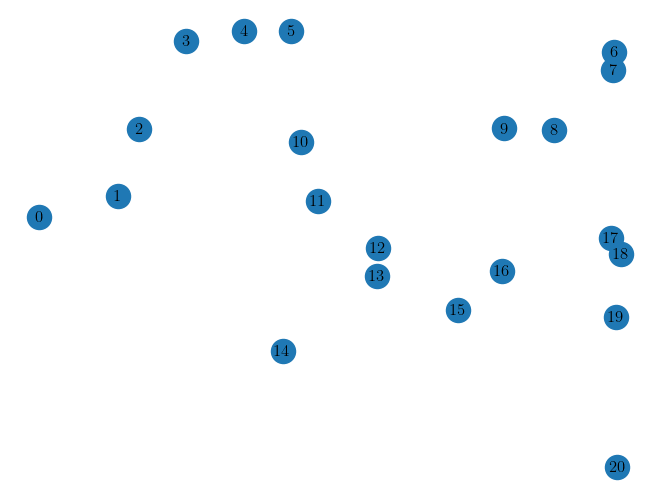

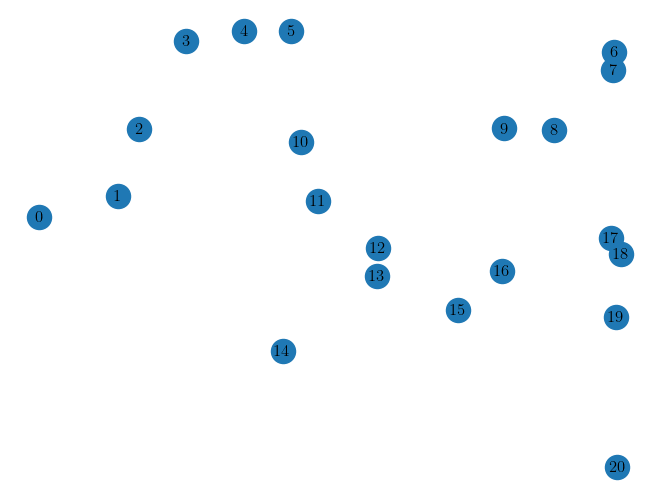

In [10]:
for i in range(0, 10+1):
    re.threshold_reachable = i / 10
    add_connections_to_map(cognitive_map, re, add=True, remove=True)
    cognitive_map.draw()
    cognitive_map.save(f'artifacts/vo_0.5_r0.{i}.gpickle', absolute_path=False)

# Adding nodes and edges to a map

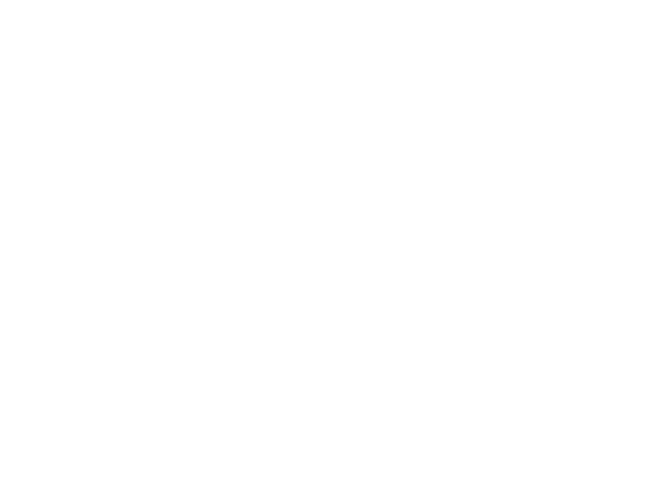

In [8]:
map_name = 'Savinov_val3'
cognitive_map = LifelongCognitiveMap(reachability_estimator=None)
node_network = cognitive_map.node_network
cognitive_map.draw()

In [9]:
#plt.switch_backend('tk')
%matplotlib qt
plot.plotTrajectoryInEnvironment(env_model=map_name, cognitive_map=cognitive_map, trajectory=False)

clicks = []
try:
    while True:
        click = plt.ginput()
        if not click:
            break
        plt.plot(click[0][0], click[0][1], 'ro')
        clicks += click
except KeyboardInterrupt:
    pass
clicks

[(-8.425403225806452, 3.56451612903226),
 (-8.425403225806452, 0.5403225806451619),
 (-8.425403225806452, -0.4274193548387091),
 (-7.336693548387097, -0.4274193548387091),
 (-7.457661290322581, -2.393145161290322),
 (-8.425403225806452, -2.423387096774193),
 (-8.425403225806452, -1.455645161290322),
 (-8.485887096774194, -4.540322580645161),
 (-4.403225806451613, -4.51008064516129),
 (-4.403225806451613, -3.421370967741935),
 (-7.487903225806452, -3.421370967741935),
 (-2.40725806451613, -3.330645161290322),
 (-2.4375, -4.479838709677419),
 (-3.375, -4.449596774193548),
 (2.370967741935484, -4.479838709677419),
 (1.493951612903226, -3.330645161290322),
 (1.463709677419354, -4.358870967741935),
 (-2.467741935483872, -2.211693548387096),
 (-1.379032258064516, -2.33266129032258),
 (-1.439516129032258, 0.6008064516129039),
 (-6.399193548387097, 0.6310483870967758),
 (-6.429435483870968, -2.544354838709677),
 (-6.429435483870968, -0.3669354838709671),
 (-6.338709677419355, 1.538306451612904

pybullet build time: Apr 30 2024 14:40:07
/tmp/ipykernel_43124/1472435974.py:9: DeprecatedWarning: setup_gc_network is deprecated
  gc_network = setup_gc_network(dt=env.dt)


Adding node: #=0, position=(-8.425403225806452, 3.56451612903226)
Adding node: #=1, position=(-8.425403225806452, 0.5403225806451619)
Adding node: #=2, position=(-8.425403225806452, -0.4274193548387091)
Adding node: #=3, position=(-7.336693548387097, -0.4274193548387091)
Adding node: #=4, position=(-7.457661290322581, -2.393145161290322)
Adding node: #=5, position=(-8.425403225806452, -2.423387096774193)
Adding node: #=6, position=(-8.425403225806452, -1.455645161290322)
Adding node: #=7, position=(-8.485887096774194, -4.540322580645161)
Adding node: #=8, position=(-4.403225806451613, -4.51008064516129)
Adding node: #=9, position=(-4.403225806451613, -3.421370967741935)
Adding node: #=10, position=(-7.487903225806452, -3.421370967741935)
Adding node: #=11, position=(-2.40725806451613, -3.330645161290322)
Adding node: #=12, position=(-2.4375, -4.479838709677419)
Adding node: #=13, position=(-3.375, -4.449596774193548)
Adding node: #=14, position=(2.370967741935484, -4.479838709677419)
A

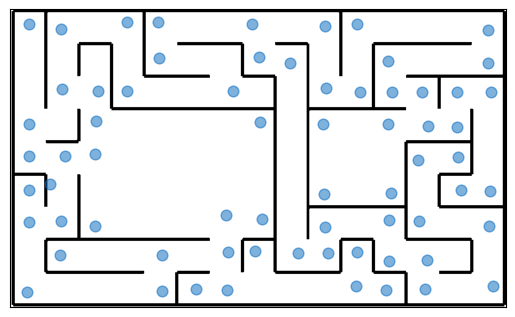

In [10]:
#plt.switch_backend('inline')
%matplotlib inline
from system.bio_model.place_cell_model import PlaceCell
from system.controller.local_controller.local_navigation import create_gc_spiking, setup_gc_network
from system.controller.reachability_estimator.data_generation.dataset import place_info
from system.controller.simulation.pybullet_environment import PybulletEnvironment

env = PybulletEnvironment(map_name, visualize=False, contains_robot=False)
gc_network = setup_gc_network(dt=env.dt)

for pos in clicks:
    angle = 0
    spiking = create_gc_spiking(start=(0, 0), goal=pos, gc_network_at_start=gc_network, plotting=False)
    data = place_info((pos, angle, spiking), env)
    pc = PlaceCell.from_data(data)
    cognitive_map.add_node_to_map(pc)
plot.plotTrajectoryInEnvironment(env_model=map_name, cognitive_map=cognitive_map, trajectory=False)

### Adding connections by hand

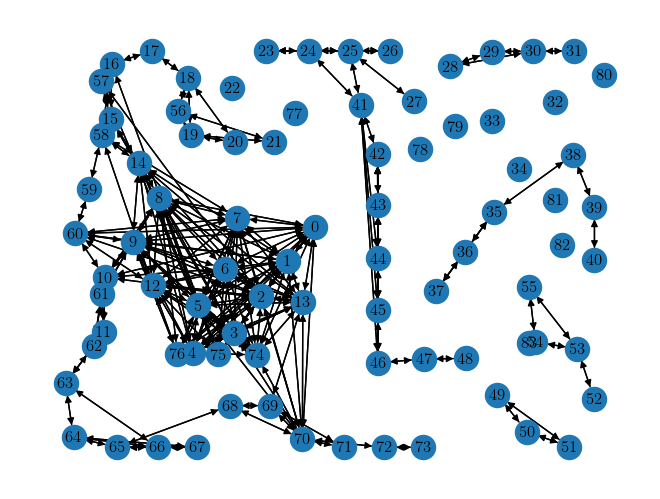

In [7]:
cognitive_map.draw()

In [18]:
G = cognitive_map.node_network
import networkx as nx
nx.get_node_attributes(G, 'pos')[nodes[20]]

(-4.086371112622932, 1.5848192420103844)

Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map
Calling add_bidirectional_edge_to_map


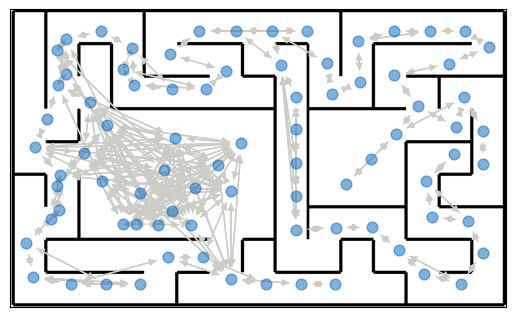

In [10]:
from system.bio_model.cognitive_map import sample_normal

nodes = list(cognitive_map.node_network)
connect = [
    (21, 77),
    (77, 22),
    (22, 23),
    (27, 78),
    (78, 79),
    (79, 28),
    (31, 80),
    (80, 32),
    (32, 33),
    (33, 34),
    (34, 35),
    (34, 81),
    (81, 38),
    (55, 82),
    (48, 49),
    (51, 52),
]
for i, j in connect:
    cognitive_map.add_bidirectional_edge_to_map(
        nodes[i], nodes[j],
        w=sample_normal(0.95, cognitive_map.sigma),
        connectivity_probability=0.95,
        mu=0.05,
        sigma=cognitive_map.sigma,
    )
plot.plotTrajectoryInEnvironment(env_model=map_name, cognitive_map=cognitive_map, trajectory=False)

In [11]:
cognitive_map.save("after_exploration.gpickle")

### Adding connections automatically

In [20]:
from system.controller.reachability_estimator.reachability_estimation import reachability_estimator_factory

re = reachability_estimator_factory('view_overlap', env_model=map_name)
re.threshold_reachable = 0.01

from functools import wraps
import numpy as np
def _wrap(fun):
    @wraps(fun)
    def _wrapper(p1, p2):
        if np.linalg.norm(np.array(p1.pos) - np.array(p2.pos)) > 2:
            return False, 0
        return fun(p1, p2)
    return _wrapper
re.get_reachability = _wrap(re.get_reachability)

add_connections_to_map(cognitive_map, re, add=True, remove=True)

Adding bidirectional edge: p=0, q=25, weight=0.9810907746448906
deleting edge [1-66]: conn 0.375
Adding bidirectional edge: p=3, q=6, weight=0.7914819501825151
Adding bidirectional edge: p=3, q=66, weight=0.2992797653460602
Adding bidirectional edge: p=5, q=2, weight=0.9081461819833522
deleting edge [5-66]: conn 0.56
deleting edge [6-3]: conn 0.185
Adding bidirectional edge: p=6, q=66, weight=0.8565113992472764
Adding bidirectional edge: p=8, q=12, weight=0.914469287750726
Adding bidirectional edge: p=9, q=11, weight=0.6395954662093284
Adding bidirectional edge: p=10, q=7, weight=0.9779232890004791
deleting edge [11-9]: conn 0.36
Adding bidirectional edge: p=11, q=13, weight=0.6512140284060354
deleting edge [12-8]: conn 0.08
deleting edge [12-29]: conn 0.34
Adding bidirectional edge: p=13, q=9, weight=0.9691270095686918
deleting edge [13-11]: conn 0.38
deleting edge [14-15]: conn 0.695
Adding bidirectional edge: p=15, q=14, weight=0.3319608036754705
deleting edge [20-24]: conn 0.53
del

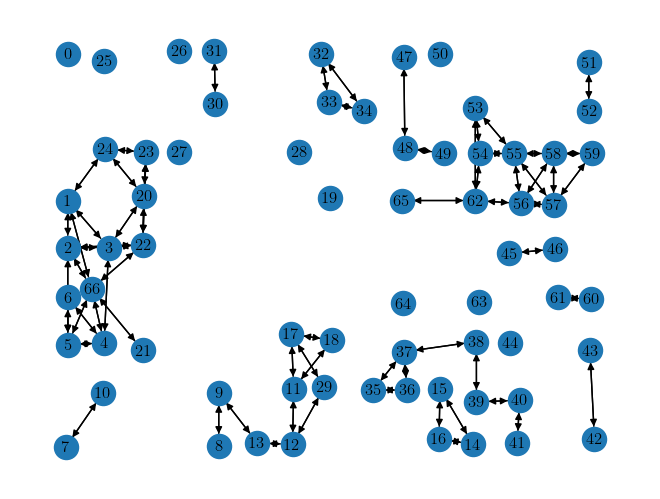

In [21]:
cognitive_map.draw()

In [59]:
cognitive_map.save("linear_sunburst.handcrafted.gpickle")

# Make the map oriented

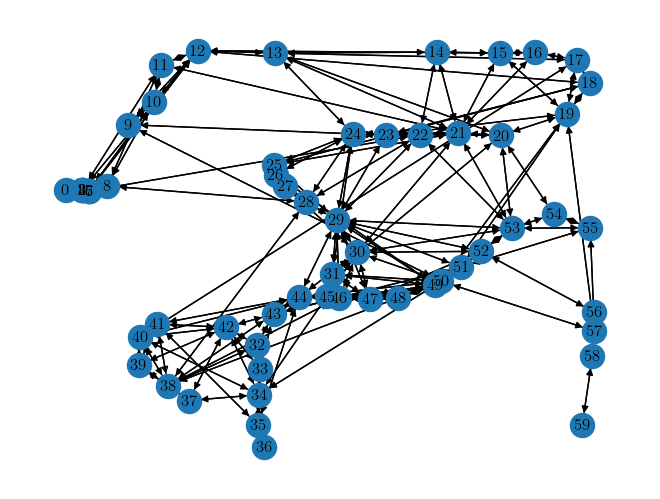

In [20]:
cogmap = LifelongCognitiveMap(None, load_data_from='cognitive_map_partial.gpickle')
env_model = 'Savinov_val3'
cogmap.draw()

In [21]:
from system.controller.simulation.pybullet_environment import PybulletEnvironment
from system.controller.reachability_estimator.data_generation.dataset import place_info
from system.bio_model.place_cell_model import PlaceCell
from tqdm import tqdm
import numpy as np

DISTANCE = 0.1

nodes = list(cogmap.node_network.nodes)
with PybulletEnvironment(env_model, contains_robot=False, visualize=False) as env:
    for node in tqdm(nodes):
        new_pos = [node.pos[0] + DISTANCE*np.cos(node.angle), node.pos[1] + DISTANCE*np.sin(node.angle)]
        inverse_angle = (node.angle + np.pi) % (2 * np.pi)
        new_node = place_info((new_pos, inverse_angle, node.spikings), env)
        new_node = PlaceCell.from_data(new_node)
        cogmap.add_node_to_map(new_node)
        for neighbour, edge in cogmap.node_network.adj[node].items():
            cogmap.add_bidirectional_edge_to_map(neighbour, new_node, w=edge['weight'])
        cogmap.add_bidirectional_edge_to_map(node, new_node)

  5%|█████████▍                                                                                                                                                                                  | 3/60 [00:00<00:02, 24.55it/s]

Adding node: #=60, position=[0.9827598914141268, 1.6720588409221253]
Adding bidirectional edge: p=1, q=60, weight=0.0574221613648944
Adding bidirectional edge: p=2, q=60, weight=0.14037283581933013
Adding bidirectional edge: p=4, q=60, weight=0.07609286957715335
Adding bidirectional edge: p=6, q=60, weight=0.1904521032733507
Adding bidirectional edge: p=3, q=60, weight=0.10246682782588984
Adding bidirectional edge: p=7, q=60, weight=0.4775097614971195
Adding bidirectional edge: p=8, q=60, weight=0.11683926695605928
Adding bidirectional edge: p=5, q=60, weight=0.25883707183808613
Adding bidirectional edge: p=0, q=60, weight=1
Adding node: #=61, position=[1.1166754653575037, 1.6711357814641588]
Adding bidirectional edge: p=0, q=61, weight=0.0574221613648944
Adding bidirectional edge: p=5, q=61, weight=0.011478909044666544
Adding bidirectional edge: p=2, q=61, weight=0.254777043376852
Adding bidirectional edge: p=60, q=61, weight=0.0574221613648944
Adding bidirectional edge: p=1, q=61, we

 10%|██████████████████▊                                                                                                                                                                         | 6/60 [00:00<00:03, 16.15it/s]

Adding bidirectional edge: p=63, q=64, weight=0.2512340969582765
Adding bidirectional edge: p=4, q=64, weight=1
Adding node: #=65, position=[1.1777466608777836, 1.6579916907576027]
Adding bidirectional edge: p=1, q=65, weight=0.011478909044666544
Adding bidirectional edge: p=2, q=65, weight=0.20793858217160033
Adding bidirectional edge: p=3, q=65, weight=0.15943656859938732
Adding bidirectional edge: p=6, q=65, weight=-0.0028716202067095905
Adding bidirectional edge: p=0, q=65, weight=0.25883707183808613
Adding bidirectional edge: p=8, q=65, weight=0.16647147988284466
Adding bidirectional edge: p=22, q=65, weight=0.2499474484646961
Adding bidirectional edge: p=60, q=65, weight=0.25883707183808613
Adding bidirectional edge: p=61, q=65, weight=0.011478909044666544
Adding bidirectional edge: p=62, q=65, weight=0.20793858217160033
Adding bidirectional edge: p=63, q=65, weight=0.15943656859938732
Adding bidirectional edge: p=5, q=65, weight=1
Adding node: #=66, position=[1.1781277623947175,

 13%|█████████████████████████                                                                                                                                                                   | 8/60 [00:00<00:03, 13.92it/s]

Adding bidirectional edge: p=8, q=67, weight=0.16907314426271378
Adding bidirectional edge: p=10, q=67, weight=0.08472844960638563
Adding bidirectional edge: p=0, q=67, weight=0.4775097614971195
Adding bidirectional edge: p=2, q=67, weight=0.12115770581243472
Adding bidirectional edge: p=6, q=67, weight=0.13173002228571393
Adding bidirectional edge: p=3, q=67, weight=0.17814867803670834
Adding bidirectional edge: p=60, q=67, weight=0.4775097614971195
Adding bidirectional edge: p=62, q=67, weight=0.12115770581243472
Adding bidirectional edge: p=63, q=67, weight=0.17814867803670834
Adding bidirectional edge: p=66, q=67, weight=0.13173002228571393
Adding bidirectional edge: p=7, q=67, weight=1
Adding node: #=68, position=[1.3301614784514333, 1.7186380235485152]
Adding bidirectional edge: p=7, q=68, weight=0.16907314426271378
Adding bidirectional edge: p=10, q=68, weight=0.09579146793613078
Adding bidirectional edge: p=0, q=68, weight=0.11683926695605928
Adding bidirectional edge: p=4, q=6

 17%|███████████████████████████████▏                                                                                                                                                           | 10/60 [00:00<00:03, 12.65it/s]

Adding bidirectional edge: p=66, q=68, weight=0.12873008525963323
Adding bidirectional edge: p=67, q=68, weight=0.16907314426271378
Adding bidirectional edge: p=8, q=68, weight=1
Adding node: #=69, position=[1.508111048193201, 2.4679481585312715]
Adding bidirectional edge: p=10, q=69, weight=0.2389836469511684
Adding bidirectional edge: p=12, q=69, weight=0.2402790094315432
Adding bidirectional edge: p=50, q=69, weight=0.7344792986653782
Adding bidirectional edge: p=23, q=69, weight=0.24919003109081747
Adding bidirectional edge: p=9, q=69, weight=1
Adding node: #=70, position=[1.7215583654006192, 2.742904402777103]
Adding bidirectional edge: p=9, q=70, weight=0.2389836469511684
Adding bidirectional edge: p=8, q=70, weight=0.09579146793613078
Adding bidirectional edge: p=7, q=70, weight=0.08472844960638563
Adding bidirectional edge: p=6, q=70, weight=0.23692388915020915
Adding bidirectional edge: p=12, q=70, weight=0.15082277585236675
Adding bidirectional edge: p=11, q=70, weight=0.2507

 23%|███████████████████████████████████████████▋                                                                                                                                               | 14/60 [00:01<00:03, 12.87it/s]

Adding bidirectional edge: p=70, q=71, weight=0.2507559511998021
Adding bidirectional edge: p=11, q=71, weight=1
Adding node: #=72, position=[2.0885399113730947, 3.3741238807084817]
Adding bidirectional edge: p=11, q=72, weight=0.1662286501878384
Adding bidirectional edge: p=10, q=72, weight=0.15082277585236675
Adding bidirectional edge: p=18, q=72, weight=0.2613615392767096
Adding bidirectional edge: p=13, q=72, weight=0.2693936014292293
Adding bidirectional edge: p=9, q=72, weight=0.2402790094315432
Adding bidirectional edge: p=15, q=72, weight=0.4301013242537003
Adding bidirectional edge: p=6, q=72, weight=0.1661853768886144
Adding bidirectional edge: p=3, q=72, weight=0.2613024419583908
Adding bidirectional edge: p=63, q=72, weight=0.2613024419583908
Adding bidirectional edge: p=66, q=72, weight=0.1661853768886144
Adding bidirectional edge: p=69, q=72, weight=0.2402790094315432
Adding bidirectional edge: p=70, q=72, weight=0.15082277585236675
Adding bidirectional edge: p=71, q=72, 

 32%|███████████████████████████████████████████████████████████▏                                                                                                                               | 19/60 [00:01<00:02, 16.12it/s]

Adding bidirectional edge: p=14, q=75, weight=0.4854568121012149
Adding bidirectional edge: p=19, q=75, weight=0.5129173214161551
Adding bidirectional edge: p=72, q=75, weight=0.4301013242537003
Adding bidirectional edge: p=74, q=75, weight=0.4854568121012149
Adding bidirectional edge: p=15, q=75, weight=1
Adding node: #=76, position=[4.916265229522349, 3.3519941273641223]
Adding bidirectional edge: p=15, q=76, weight=0.24071081093123958
Adding bidirectional edge: p=17, q=76, weight=0.5056640994659982
Adding bidirectional edge: p=21, q=76, weight=0.2594015559059312
Adding bidirectional edge: p=75, q=76, weight=0.24071081093123958
Adding bidirectional edge: p=16, q=76, weight=1
Adding node: #=77, position=[5.260465036911746, 3.259780941594983]
Adding bidirectional edge: p=16, q=77, weight=0.5056640994659982
Adding bidirectional edge: p=13, q=77, weight=0.2573053472228199
Adding bidirectional edge: p=18, q=77, weight=0.4969801630272347
Adding bidirectional edge: p=19, q=77, weight=0.2465

 35%|█████████████████████████████████████████████████████████████████▍                                                                                                                         | 21/60 [00:01<00:02, 14.82it/s]

Adding bidirectional edge: p=51, q=79, weight=0.24994512144198958
Adding bidirectional edge: p=23, q=79, weight=0.291080573811066
Adding bidirectional edge: p=17, q=79, weight=0.24657762410430786
Adding bidirectional edge: p=15, q=79, weight=0.5129173214161551
Adding bidirectional edge: p=75, q=79, weight=0.5129173214161551
Adding bidirectional edge: p=77, q=79, weight=0.24657762410430786
Adding bidirectional edge: p=78, q=79, weight=0.4763306533234045
Adding bidirectional edge: p=19, q=79, weight=1
Adding node: #=80, position=[4.627159894925477, 2.336229609507922]
Adding bidirectional edge: p=53, q=80, weight=0.4928004585171604
Adding bidirectional edge: p=21, q=80, weight=0.2865520363617076
Adding bidirectional edge: p=19, q=80, weight=0.500954413185291
Adding bidirectional edge: p=31, q=80, weight=0.24718931758835744
Adding bidirectional edge: p=24, q=80, weight=0.2643018487647808
Adding bidirectional edge: p=13, q=80, weight=0.17620931909594503
Adding bidirectional edge: p=54, q=80

 38%|███████████████████████████████████████████████████████████████████████▋                                                                                                                   | 23/60 [00:01<00:02, 12.34it/s]

Adding bidirectional edge: p=74, q=81, weight=0.3188816072550416
Adding bidirectional edge: p=75, q=81, weight=0.2210547994219127
Adding bidirectional edge: p=76, q=81, weight=0.2594015559059312
Adding bidirectional edge: p=80, q=81, weight=0.2865520363617076
Adding bidirectional edge: p=21, q=81, weight=1
Adding node: #=82, position=[3.9465163491563584, 2.34377910494175]
Adding bidirectional edge: p=23, q=82, weight=0.45798498751320826
Adding bidirectional edge: p=24, q=82, weight=0.2297545492916192
Adding bidirectional edge: p=14, q=82, weight=0.48877989576738545
Adding bidirectional edge: p=28, q=82, weight=0.42111319309640527
Adding bidirectional edge: p=29, q=82, weight=0.44182892659136075
Adding bidirectional edge: p=21, q=82, weight=0.5284778044325333
Adding bidirectional edge: p=53, q=82, weight=0.5116631434909522
Adding bidirectional edge: p=5, q=82, weight=0.2499474484646961
Adding bidirectional edge: p=65, q=82, weight=0.2499474484646961
Adding bidirectional edge: p=74, q=82

 42%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 25/60 [00:01<00:03,  9.94it/s]

Adding bidirectional edge: p=82, q=83, weight=0.45798498751320826
Adding bidirectional edge: p=23, q=83, weight=1
Adding node: #=84, position=[3.38633572708209, 2.3567527560897785]
Adding bidirectional edge: p=29, q=84, weight=0.24386305682574205
Adding bidirectional edge: p=26, q=84, weight=0.10632192646152275
Adding bidirectional edge: p=21, q=84, weight=0.11286079002975136
Adding bidirectional edge: p=13, q=84, weight=0.3378700137322921
Adding bidirectional edge: p=23, q=84, weight=0.5187593042701548
Adding bidirectional edge: p=22, q=84, weight=0.2297545492916192
Adding bidirectional edge: p=20, q=84, weight=0.2643018487647808
Adding bidirectional edge: p=28, q=84, weight=0.5206730600871194
Adding bidirectional edge: p=25, q=84, weight=0.2589889250529695
Adding bidirectional edge: p=31, q=84, weight=0.24727765917779537
Adding bidirectional edge: p=73, q=84, weight=0.3378700137322921
Adding bidirectional edge: p=80, q=84, weight=0.2643018487647808
Adding bidirectional edge: p=81, q=

 45%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 27/60 [00:02<00:03, 10.74it/s]

Adding bidirectional edge: p=81, q=85, weight=0.25148149096132516
Adding bidirectional edge: p=84, q=85, weight=0.2589889250529695
Adding bidirectional edge: p=25, q=85, weight=1
Adding node: #=86, position=[2.7406269820709035, 1.8575763538987977]
Adding bidirectional edge: p=27, q=86, weight=0.0096608702464974
Adding bidirectional edge: p=28, q=86, weight=0.49916626439318273
Adding bidirectional edge: p=24, q=86, weight=0.10632192646152275
Adding bidirectional edge: p=49, q=86, weight=0.25737833180654224
Adding bidirectional edge: p=25, q=86, weight=0.5090491809312075
Adding bidirectional edge: p=84, q=86, weight=0.10632192646152275
Adding bidirectional edge: p=85, q=86, weight=0.5090491809312075
Adding bidirectional edge: p=26, q=86, weight=1
Adding node: #=87, position=[2.8169924525901533, 1.7211118682727373]
Adding bidirectional edge: p=26, q=87, weight=0.0096608702464974
Adding bidirectional edge: p=28, q=87, weight=0.12179316066005853
Adding bidirectional edge: p=25, q=87, weight

 48%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 29/60 [00:02<00:02, 10.37it/s]

Adding bidirectional edge: p=38, q=88, weight=0.24449493443566628
Adding bidirectional edge: p=68, q=88, weight=0.2700876413294399
Adding bidirectional edge: p=82, q=88, weight=0.42111319309640527
Adding bidirectional edge: p=84, q=88, weight=0.5206730600871194
Adding bidirectional edge: p=86, q=88, weight=0.49916626439318273
Adding bidirectional edge: p=87, q=88, weight=0.12179316066005853
Adding bidirectional edge: p=28, q=88, weight=1
Adding node: #=89, position=[3.2510623740421223, 1.3015338705733055]
Adding bidirectional edge: p=30, q=89, weight=0.09455476719501828
Adding bidirectional edge: p=52, q=89, weight=0.23618348383562146
Adding bidirectional edge: p=49, q=89, weight=0.27360560732852435
Adding bidirectional edge: p=46, q=89, weight=0.09373070551044803
Adding bidirectional edge: p=24, q=89, weight=0.24386305682574205
Adding bidirectional edge: p=23, q=89, weight=0.2408404141174973
Adding bidirectional edge: p=25, q=89, weight=0.2601592026565713
Adding bidirectional edge: p=

 52%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 31/60 [00:02<00:03,  8.33it/s]

Adding bidirectional edge: p=84, q=89, weight=0.24386305682574205
Adding bidirectional edge: p=85, q=89, weight=0.2601592026565713
Adding bidirectional edge: p=88, q=89, weight=0.2971364886952448
Adding bidirectional edge: p=29, q=89, weight=1
Adding node: #=90, position=[3.425357065838257, 0.9057553159920253]
Adding bidirectional edge: p=31, q=90, weight=0.23916770324211822
Adding bidirectional edge: p=29, q=90, weight=0.09455476719501828
Adding bidirectional edge: p=50, q=90, weight=0.3308473193652639
Adding bidirectional edge: p=52, q=90, weight=0.48335366776215954
Adding bidirectional edge: p=46, q=90, weight=0.5122393375972246
Adding bidirectional edge: p=47, q=90, weight=0.25400165695076493
Adding bidirectional edge: p=27, q=90, weight=0.10192479671788239
Adding bidirectional edge: p=44, q=90, weight=0.5068158076993451
Adding bidirectional edge: p=34, q=90, weight=0.5943275409021217
Adding bidirectional edge: p=21, q=90, weight=0.16493529824249928
Adding bidirectional edge: p=45,

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 34/60 [00:02<00:02, 10.24it/s]

Adding bidirectional edge: p=30, q=91, weight=0.23916770324211822
Adding bidirectional edge: p=47, q=91, weight=0.48832992117198504
Adding bidirectional edge: p=46, q=91, weight=0.23664374536849353
Adding bidirectional edge: p=49, q=91, weight=0.24051620191742054
Adding bidirectional edge: p=20, q=91, weight=0.24718931758835744
Adding bidirectional edge: p=24, q=91, weight=0.24727765917779537
Adding bidirectional edge: p=29, q=91, weight=0.25507918733376683
Adding bidirectional edge: p=80, q=91, weight=0.24718931758835744
Adding bidirectional edge: p=84, q=91, weight=0.24727765917779537
Adding bidirectional edge: p=89, q=91, weight=0.25507918733376683
Adding bidirectional edge: p=90, q=91, weight=0.23916770324211822
Adding bidirectional edge: p=31, q=91, weight=1
Adding node: #=92, position=[2.5847558559651493, -0.23191598852611858]
Adding bidirectional edge: p=33, q=92, weight=0.0005173618308568929
Adding bidirectional edge: p=36, q=92, weight=0.17998548472224835
Adding bidirectional 

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 36/60 [00:03<00:02, 11.02it/s]

Adding bidirectional edge: p=50, q=94, weight=0.25946053186017376
Adding bidirectional edge: p=40, q=94, weight=0.2532895690415732
Adding bidirectional edge: p=30, q=94, weight=0.5943275409021217
Adding bidirectional edge: p=90, q=94, weight=0.5943275409021217
Adding bidirectional edge: p=92, q=94, weight=0.2519133918902543
Adding bidirectional edge: p=93, q=94, weight=0.4979714748868913
Adding bidirectional edge: p=34, q=94, weight=1
Adding node: #=95, position=[2.5925330570995353, -1.206271016080088]
Adding bidirectional edge: p=34, q=95, weight=0.13112702616571925
Adding bidirectional edge: p=41, q=95, weight=0.2428315198219499
Adding bidirectional edge: p=44, q=95, weight=0.1350787974125924
Adding bidirectional edge: p=36, q=95, weight=0.23762425532654466
Adding bidirectional edge: p=94, q=95, weight=0.13112702616571925
Adding bidirectional edge: p=35, q=95, weight=1
Adding node: #=96, position=[2.6465664808233593, -1.4808429855793643]
Adding bidirectional edge: p=32, q=96, weight=

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 39/60 [00:03<00:01, 11.94it/s]

Adding bidirectional edge: p=32, q=98, weight=0.24938079418305134
Adding bidirectional edge: p=43, q=98, weight=0.21093122058024902
Adding bidirectional edge: p=50, q=98, weight=0.2662112437955736
Adding bidirectional edge: p=46, q=98, weight=0.27290818029722164
Adding bidirectional edge: p=28, q=98, weight=0.24449493443566628
Adding bidirectional edge: p=41, q=98, weight=0.24363901708325758
Adding bidirectional edge: p=88, q=98, weight=0.24449493443566628
Adding bidirectional edge: p=92, q=98, weight=0.24938079418305134
Adding bidirectional edge: p=97, q=98, weight=-0.0005182033143970924
Adding bidirectional edge: p=38, q=98, weight=1
Adding node: #=99, position=[1.5936304886838313, -0.4757916859504512]
Adding bidirectional edge: p=37, q=99, weight=0.08569720864060351
Adding bidirectional edge: p=38, q=99, weight=0.25508710403501283
Adding bidirectional edge: p=40, q=99, weight=0.5063022893583627
Adding bidirectional edge: p=42, q=99, weight=0.2538173889801026
Adding bidirectional edg

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 41/60 [00:03<00:01, 11.55it/s]

Adding bidirectional edge: p=44, q=100, weight=0.25678117641814197
Adding bidirectional edge: p=17, q=100, weight=0.24161507217398162
Adding bidirectional edge: p=77, q=100, weight=0.24161507217398162
Adding bidirectional edge: p=94, q=100, weight=0.2532895690415732
Adding bidirectional edge: p=98, q=100, weight=0.10230730983886505
Adding bidirectional edge: p=99, q=100, weight=0.5063022893583627
Adding bidirectional edge: p=40, q=100, weight=1
Adding node: #=101, position=[1.7495579327585644, 0.028205047312612225]
Adding bidirectional edge: p=40, q=101, weight=0.16166241754828334
Adding bidirectional edge: p=35, q=101, weight=0.2428315198219499
Adding bidirectional edge: p=42, q=101, weight=0.25325604109394706
Adding bidirectional edge: p=44, q=101, weight=0.19237905583135567
Adding bidirectional edge: p=39, q=101, weight=0.47493785250921194
Adding bidirectional edge: p=38, q=101, weight=0.24363901708325758
Adding bidirectional edge: p=95, q=101, weight=0.2428315198219499
Adding bidir

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 43/60 [00:03<00:01,  8.80it/s]

Adding bidirectional edge: p=41, q=101, weight=1
Adding node: #=102, position=[2.3283177631430414, -0.012232064369331365]
Adding bidirectional edge: p=34, q=102, weight=0.10842084109961103
Adding bidirectional edge: p=33, q=102, weight=0.4866326799387044
Adding bidirectional edge: p=43, q=102, weight=0.2510818863882316
Adding bidirectional edge: p=41, q=102, weight=0.25325604109394706
Adding bidirectional edge: p=32, q=102, weight=0.24153291003295943
Adding bidirectional edge: p=40, q=102, weight=0.4956410105699945
Adding bidirectional edge: p=39, q=102, weight=0.2538173889801026
Adding bidirectional edge: p=37, q=102, weight=0.4924820211442984
Adding bidirectional edge: p=92, q=102, weight=0.24153291003295943
Adding bidirectional edge: p=93, q=102, weight=0.4866326799387044
Adding bidirectional edge: p=94, q=102, weight=0.10842084109961103
Adding bidirectional edge: p=97, q=102, weight=0.4924820211442984
Adding bidirectional edge: p=99, q=102, weight=0.2538173889801026
Adding bidirect

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 45/60 [00:04<00:01,  8.30it/s]

Adding bidirectional edge: p=101, q=104, weight=0.19237905583135567
Adding bidirectional edge: p=103, q=104, weight=0.13824812393299432
Adding bidirectional edge: p=44, q=104, weight=1
Adding node: #=105, position=[3.170555438448608, 0.36567508610968863]
Adding bidirectional edge: p=46, q=105, weight=0.014058630731760847
Adding bidirectional edge: p=44, q=105, weight=0.28927821826962713
Adding bidirectional edge: p=30, q=105, weight=0.15809370471591808
Adding bidirectional edge: p=90, q=105, weight=0.15809370471591808
Adding bidirectional edge: p=104, q=105, weight=0.28927821826962713
Adding bidirectional edge: p=45, q=105, weight=1
Adding node: #=106, position=[3.2743170736457037, 0.35173171729557356]
Adding bidirectional edge: p=45, q=106, weight=0.014058630731760847
Adding bidirectional edge: p=47, q=106, weight=0.18245016989218038
Adding bidirectional edge: p=29, q=106, weight=0.09373070551044803
Adding bidirectional edge: p=30, q=106, weight=0.5122393375972246
Adding bidirectional

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 47/60 [00:04<00:01,  7.67it/s]

Adding bidirectional edge: p=38, q=106, weight=0.27290818029722164
Adding bidirectional edge: p=89, q=106, weight=0.09373070551044803
Adding bidirectional edge: p=90, q=106, weight=0.5122393375972246
Adding bidirectional edge: p=91, q=106, weight=0.23664374536849353
Adding bidirectional edge: p=98, q=106, weight=0.27290818029722164
Adding bidirectional edge: p=103, q=106, weight=0.2601803940504825
Adding bidirectional edge: p=104, q=106, weight=0.4909826672266603
Adding bidirectional edge: p=105, q=106, weight=0.014058630731760847
Adding bidirectional edge: p=46, q=106, weight=1
Adding node: #=107, position=[3.5280205572817596, 0.3315292174708287]
Adding bidirectional edge: p=46, q=107, weight=0.18245016989218038
Adding bidirectional edge: p=48, q=107, weight=0.1326937626639665
Adding bidirectional edge: p=31, q=107, weight=0.48832992117198504
Adding bidirectional edge: p=30, q=107, weight=0.25400165695076493
Adding bidirectional edge: p=50, q=107, weight=0.16871041723181648
Adding bid

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 48/60 [00:04<00:01,  7.25it/s]

Adding bidirectional edge: p=90, q=107, weight=0.25400165695076493
Adding bidirectional edge: p=91, q=107, weight=0.48832992117198504
Adding bidirectional edge: p=106, q=107, weight=0.18245016989218038
Adding bidirectional edge: p=47, q=107, weight=1
Adding node: #=108, position=[3.763704901370275, 0.3468250828193836]
Adding bidirectional edge: p=47, q=108, weight=0.1326937626639665
Adding bidirectional edge: p=49, q=108, weight=0.481437042186826
Adding bidirectional edge: p=50, q=108, weight=0.5181724422554377
Adding bidirectional edge: p=107, q=108, weight=0.1326937626639665
Adding bidirectional edge: p=48, q=108, weight=1
Adding node: #=109, position=[4.0764208230443435, 0.5029620290329656]
Adding bidirectional edge: p=50, q=109, weight=0.031523738892324044
Adding bidirectional edge: p=48, q=109, weight=0.481437042186826
Adding bidirectional edge: p=29, q=109, weight=0.27360560732852435
Adding bidirectional edge: p=31, q=109, weight=0.24051620191742054
Adding bidirectional edge: p=2

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 50/60 [00:04<00:01,  7.29it/s]

Adding bidirectional edge: p=91, q=109, weight=0.24051620191742054
Adding bidirectional edge: p=106, q=109, weight=0.2222319968598201
Adding bidirectional edge: p=107, q=109, weight=0.4832617421933061
Adding bidirectional edge: p=108, q=109, weight=0.481437042186826
Adding bidirectional edge: p=49, q=109, weight=1
Adding node: #=110, position=[4.128725785677461, 0.5519473722908944]
Adding bidirectional edge: p=49, q=110, weight=0.031523738892324044
Adding bidirectional edge: p=51, q=110, weight=0.0037538096808085
Adding bidirectional edge: p=31, q=110, weight=0.1319594067608184
Adding bidirectional edge: p=30, q=110, weight=0.3308473193652639
Adding bidirectional edge: p=52, q=110, weight=0.5014658730471218
Adding bidirectional edge: p=47, q=110, weight=0.16871041723181648
Adding bidirectional edge: p=48, q=110, weight=0.5181724422554377
Adding bidirectional edge: p=44, q=110, weight=0.12709162327191
Adding bidirectional edge: p=34, q=110, weight=0.25946053186017376
Adding bidirectiona

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 51/60 [00:05<00:01,  5.67it/s]

Adding bidirectional edge: p=69, q=110, weight=0.7344792986653782
Adding bidirectional edge: p=79, q=110, weight=0.23883366875033832
Adding bidirectional edge: p=90, q=110, weight=0.3308473193652639
Adding bidirectional edge: p=91, q=110, weight=0.1319594067608184
Adding bidirectional edge: p=94, q=110, weight=0.25946053186017376
Adding bidirectional edge: p=98, q=110, weight=0.2662112437955736
Adding bidirectional edge: p=104, q=110, weight=0.12709162327191
Adding bidirectional edge: p=107, q=110, weight=0.16871041723181648
Adding bidirectional edge: p=108, q=110, weight=0.5181724422554377
Adding bidirectional edge: p=109, q=110, weight=0.031523738892324044
Adding bidirectional edge: p=50, q=110, weight=1
Adding node: #=111, position=[4.290467628146987, 0.7253106878280411]
Adding bidirectional edge: p=50, q=111, weight=0.0037538096808085
Adding bidirectional edge: p=52, q=111, weight=0.5223368941716997
Adding bidirectional edge: p=19, q=111, weight=0.24994512144198958
Adding bidirecti

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 52/60 [00:05<00:01,  5.83it/s]

Adding bidirectional edge: p=89, q=111, weight=0.24686743941722322
Adding bidirectional edge: p=103, q=111, weight=0.24215022045976425
Adding bidirectional edge: p=110, q=111, weight=0.0037538096808085
Adding bidirectional edge: p=51, q=111, weight=1
Adding node: #=112, position=[4.459915000911598, 0.9184542892187739]
Adding bidirectional edge: p=51, q=112, weight=0.5223368941716997
Adding bidirectional edge: p=50, q=112, weight=0.5014658730471218
Adding bidirectional edge: p=30, q=112, weight=0.48335366776215954
Adding bidirectional edge: p=53, q=112, weight=0.11612390794772649
Adding bidirectional edge: p=29, q=112, weight=0.23618348383562146
Adding bidirectional edge: p=47, q=112, weight=0.25228194926819486
Adding bidirectional edge: p=56, q=112, weight=0.5108120542802442
Adding bidirectional edge: p=89, q=112, weight=0.23618348383562146
Adding bidirectional edge: p=90, q=112, weight=0.48335366776215954
Adding bidirectional edge: p=107, q=112, weight=0.25228194926819486
Adding bidir

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 53/60 [00:05<00:01,  5.68it/s]

Adding bidirectional edge: p=111, q=112, weight=0.5223368941716997
Adding bidirectional edge: p=52, q=112, weight=1
Adding node: #=113, position=[4.719831458686025, 1.2000738315816435]
Adding bidirectional edge: p=52, q=113, weight=0.11612390794772649
Adding bidirectional edge: p=54, q=113, weight=0.10079391897729416
Adding bidirectional edge: p=20, q=113, weight=0.4928004585171604
Adding bidirectional edge: p=55, q=113, weight=0.1433954402650817
Adding bidirectional edge: p=21, q=113, weight=0.18269001942930702
Adding bidirectional edge: p=22, q=113, weight=0.5116631434909522
Adding bidirectional edge: p=29, q=113, weight=0.5056617897331316
Adding bidirectional edge: p=50, q=113, weight=0.2425345541940674
Adding bidirectional edge: p=30, q=113, weight=0.24415845733454405
Adding bidirectional edge: p=80, q=113, weight=0.4928004585171604
Adding bidirectional edge: p=81, q=113, weight=0.18269001942930702
Adding bidirectional edge: p=82, q=113, weight=0.5116631434909522
Adding bidirection

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 54/60 [00:05<00:01,  5.24it/s]

Adding bidirectional edge: p=112, q=113, weight=0.11612390794772649
Adding bidirectional edge: p=53, q=113, weight=1
Adding node: #=114, position=[5.069245720709464, 1.3732239667693515]
Adding bidirectional edge: p=53, q=114, weight=0.10079391897729416
Adding bidirectional edge: p=55, q=114, weight=0.13104615464673489
Adding bidirectional edge: p=20, q=114, weight=0.24741106562595766
Adding bidirectional edge: p=80, q=114, weight=0.24741106562595766
Adding bidirectional edge: p=113, q=114, weight=0.10079391897729416
Adding bidirectional edge: p=54, q=114, weight=1
Adding node: #=115, position=[5.3741618476579935, 1.2072889791863426]
Adding bidirectional edge: p=54, q=115, weight=0.13104615464673489
Adding bidirectional edge: p=53, q=115, weight=0.1433954402650817
Adding bidirectional edge: p=57, q=115, weight=0.24807175201366347
Adding bidirectional edge: p=51, q=115, weight=0.2727295229390495
Adding bidirectional edge: p=111, q=115, weight=0.2727295229390495
Adding bidirectional edge:

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 58/60 [00:06<00:00,  7.68it/s]

Adding bidirectional edge: p=55, q=115, weight=1
Adding node: #=116, position=[5.409818085205589, 0.17256121056848256]
Adding bidirectional edge: p=57, q=116, weight=0.4880537895290664
Adding bidirectional edge: p=58, q=116, weight=-0.0016945921331980238
Adding bidirectional edge: p=52, q=116, weight=0.5108120542802442
Adding bidirectional edge: p=112, q=116, weight=0.5108120542802442
Adding bidirectional edge: p=56, q=116, weight=1
Adding node: #=117, position=[5.409597142428695, -0.05681057683404639]
Adding bidirectional edge: p=56, q=117, weight=0.4880537895290664
Adding bidirectional edge: p=58, q=117, weight=0.006016330252257161
Adding bidirectional edge: p=55, q=117, weight=0.24807175201366347
Adding bidirectional edge: p=19, q=117, weight=0.2657539705163087
Adding bidirectional edge: p=50, q=117, weight=0.5181921494108084
Adding bidirectional edge: p=79, q=117, weight=0.2657539705163087
Adding bidirectional edge: p=110, q=117, weight=0.5181921494108084
Adding bidirectional edge:

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.50it/s]

Adding bidirectional edge: p=57, q=118, weight=0.006016330252257161
Adding bidirectional edge: p=59, q=118, weight=0.5267041364465458
Adding bidirectional edge: p=116, q=118, weight=-0.0016945921331980238
Adding bidirectional edge: p=117, q=118, weight=0.006016330252257161
Adding bidirectional edge: p=58, q=118, weight=1
Adding node: #=119, position=[5.307399149864467, -1.2083089381240482]
Adding bidirectional edge: p=58, q=119, weight=0.5267041364465458
Adding bidirectional edge: p=118, q=119, weight=0.5267041364465458
Adding bidirectional edge: p=59, q=119, weight=1


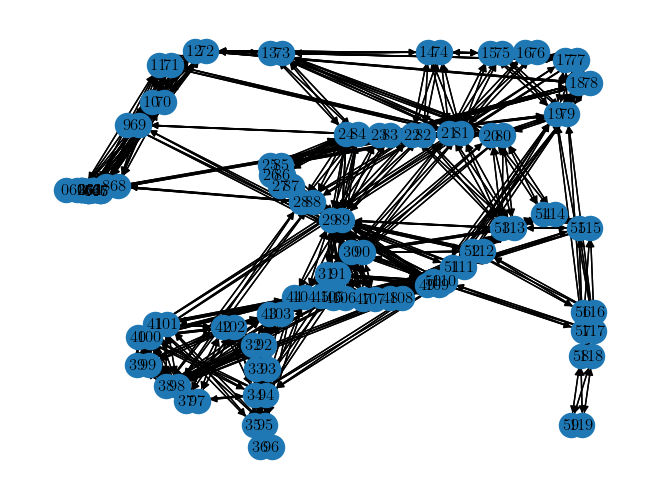

In [22]:
[pc.angle for pc in cogmap.node_network.nodes]
cogmap.draw()

In [19]:
cogmap.save('directional.gpickle')

# Displaying different maps

In [3]:
def draw_map(file, env_model, env_variant=None):
    default_variants = {'linear_sunburst': 'plane', 'Savinov_val3': ''}
    env_variant = env_variant or default_variants[env_model]
    cognitive_map = LifelongCognitiveMap(reachability_estimator=None, load_data_from=file, debug=False)
    print(f"{file} ({len(cognitive_map.node_network.nodes)} nodes)")
    print("metadata:", cognitive_map.node_network.graph)
    plot.plotTrajectoryInEnvironment(env_model=env_model, env_variant=env_variant, cognitive_map=cognitive_map, trajectory=False)

linear_sunburst.after_exploration.gpickle (18 nodes)
metadata: {'threshold': 0.7999999999999999}


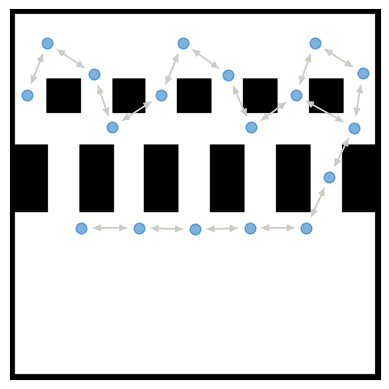

In [4]:
draw_map("linear_sunburst.after_exploration.gpickle", "linear_sunburst")

cognitive_map_partial_2.gpickle (97 nodes)


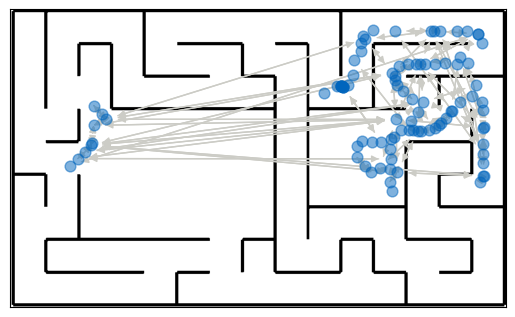

disjoint.gpickle (201 nodes)


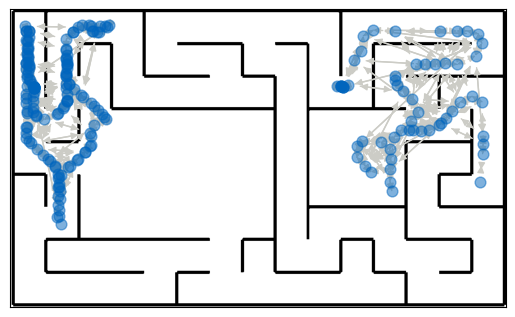

handcrafted.gpickle (99 nodes)


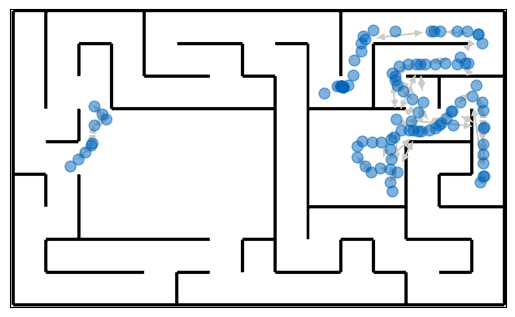

after_lifelong_learning.gpickle (98 nodes)


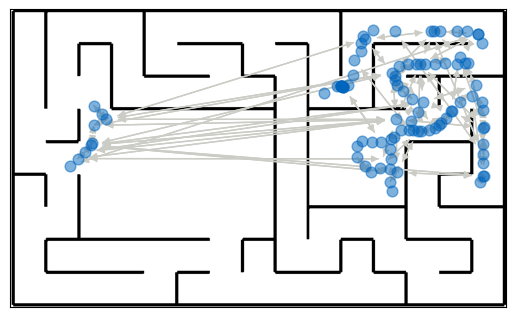

cognitive_map_full.gpickle (102 nodes)


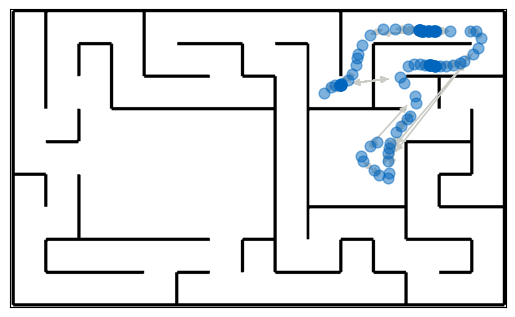

linear_sunburst.handcrafted.gpickle (28 nodes)


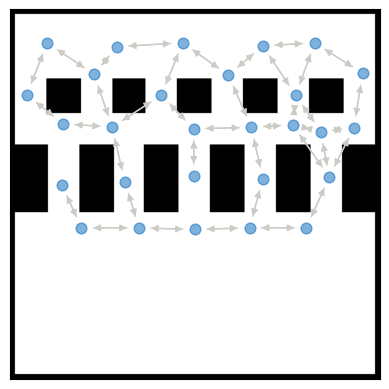

linear_sunburst.after_lifelong_learning.gpickle (25 nodes)


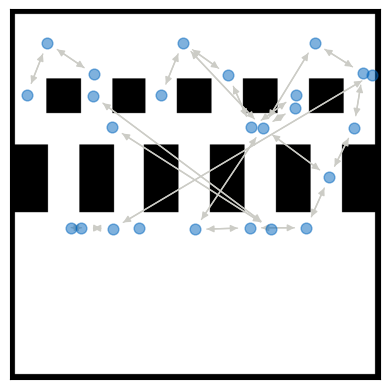

after_exploration.gpickle (77 nodes)


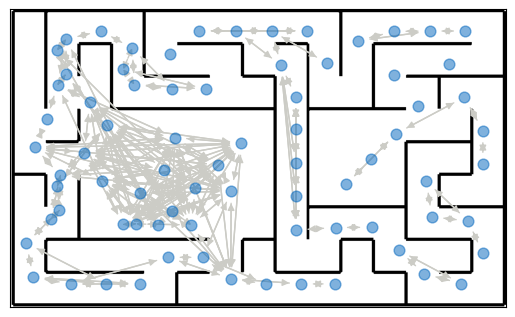

cognitive_map_partial.gpickle (60 nodes)


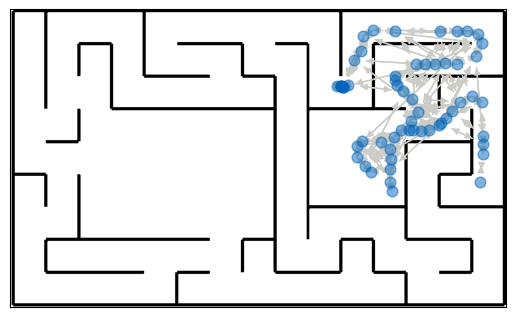

linear_sunburst.after_exploration+re--network.gpickle (27 nodes)


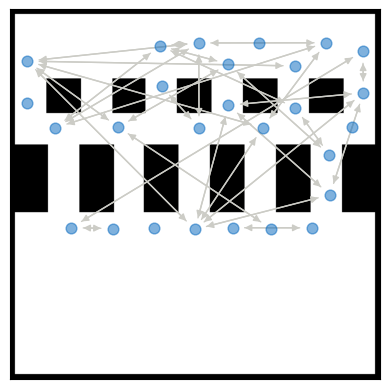

linear_sunburst.after_exploration.gpickle (18 nodes)


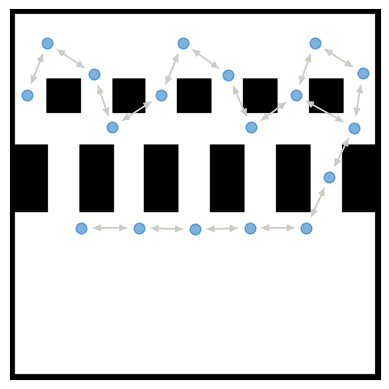

cognitive_map_partial_3.gpickle (141 nodes)


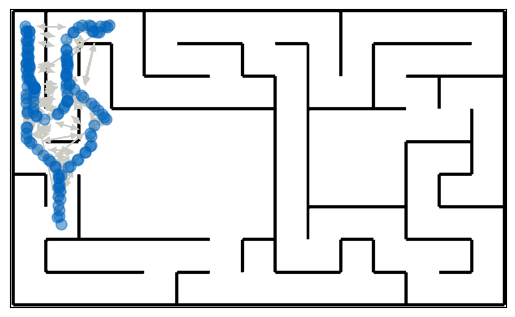

In [4]:
import os
for filename in os.listdir("../system/bio_model/data/cognitive_map"):
    match filename.split("."):
        case (env_model, _type, "gpickle"):
            draw_map(filename, env_model)
        case (type, "gpickle"):
            draw_map(filename, "Savinov_val3")

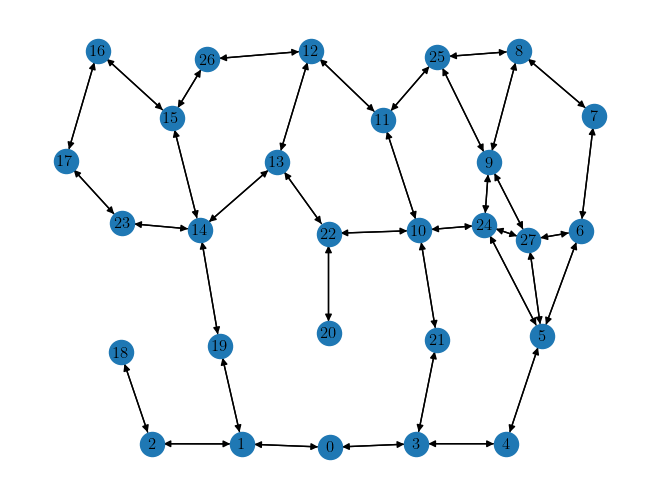

In [5]:
map_name = "linear_sunburst.handcrafted.gpickle"
map = LifelongCognitiveMap(reachability_estimator=None, load_data_from=map_name, debug=True)
map.draw()

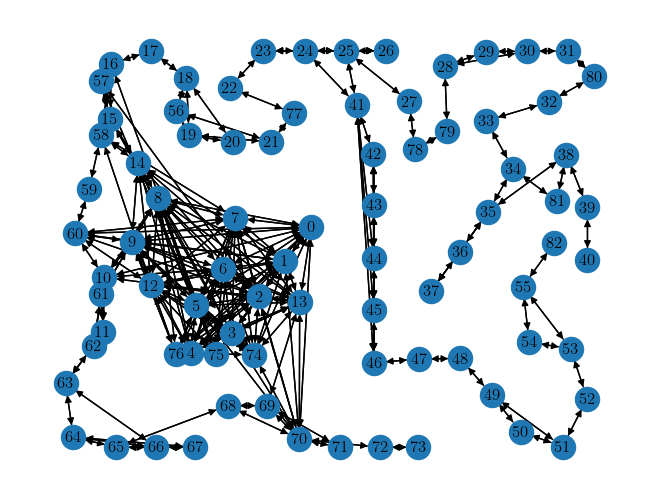

In [7]:
map_name = "after_exploration.gpickle"
map = LifelongCognitiveMap(reachability_estimator=None, load_data_from=map_name, debug=True)
map.draw()

## Displaying info of a particular node

In [9]:
cogmap = LifelongCognitiveMap(None, load_data_from='after_exploration.gpickle')
pc_network = cogmap.get_place_cell_network()
env_model = 'Savinov_val3'
inode = 49
pc = pc_network.place_cells[inode]

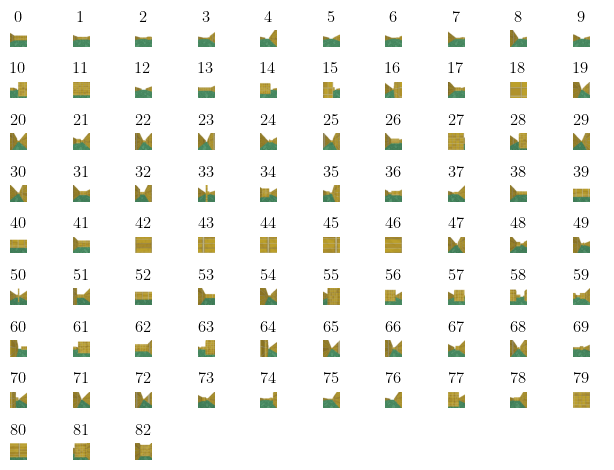

In [19]:
import matplotlib.pyplot as plt
from system.plotting.plotHelper import add_environment
import math

fig, axes = plt.subplots(math.ceil(len(pc_network.place_cells)/10), 10)
axes = axes.flatten()
for ax in axes: ax.set_axis_off()
for i, (pc, ax) in enumerate(zip(pc_network.place_cells, axes)):
    ax.imshow(pc.img)
    ax.set_title(str(i))
fig.tight_layout()